# Compare VGGFace implementations
Compare inference result from TensorFlow implementation to result from pure Python + Numpy implementation.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets
import tensorflow as tf
import numpy as np
import requests
import os
import requests
from PIL import Image
from io import BytesIO
from scipy.misc import imread
from skimage.transform import resize
import math
from vggface.tf_vggface_v2 import VGGFace as TfVGGFace
from vggface.model import VGGFace as MyVGGFace
import random
import json
import re


dataset_path = "/media/explicat/Moosilauke/ctf/facescrub/training"
tf_checkpoint_dir = "/media/explicat/Moosilauke/ctf/vggface/checkpoint_pretrained_530_lr_0.000001"
my_cnn_weights_file = "/home/explicat/ctf/jodlgang/prototype/vggface/weights_pretrained_530_lr_0.000001.h5"
num_classes = 530

Find all image files.

In [2]:
img_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(dataset_path) for f in filenames if re.search(".(jpg|jpeg|png)$", f.lower()) is not None]
random.shuffle(img_files)

Load the trained models.

In [3]:
sess = tf.InteractiveSession()
tf_cnn = TfVGGFace(sess, num_classes)
tf_cnn.load(tf_checkpoint_dir)

my_cnn = MyVGGFace()
my_cnn.restore_weights(my_cnn_weights_file)

Attempting to read checkpoint from /media/explicat/Moosilauke/ctf/vggface/checkpoint_pretrained_530_lr_0.000001
INFO:tensorflow:Restoring parameters from /media/explicat/Moosilauke/ctf/vggface/checkpoint_pretrained_530_lr_0.000001/VGGFace_v2-78000
Successfully restored checkpoint


Load the mapping from class number to person.

In [4]:
name_to_class_label_mapping_file = os.path.join(dataset_path, "class_label_mapping.json")
with open(name_to_class_label_mapping_file, "r") as f:
    name_to_class_label_mapping = json.load(f)

## Inference time

In [5]:
def decode_single_prediction(probabilities):
    top_5_classes = np.argsort(-probabilities)[:5]
    top_5_identities = np.array(name_to_class_label_mapping)[top_5_classes]
    return list(zip(top_5_identities, probabilities[top_5_classes]))

<IPython.core.display.Javascript object>


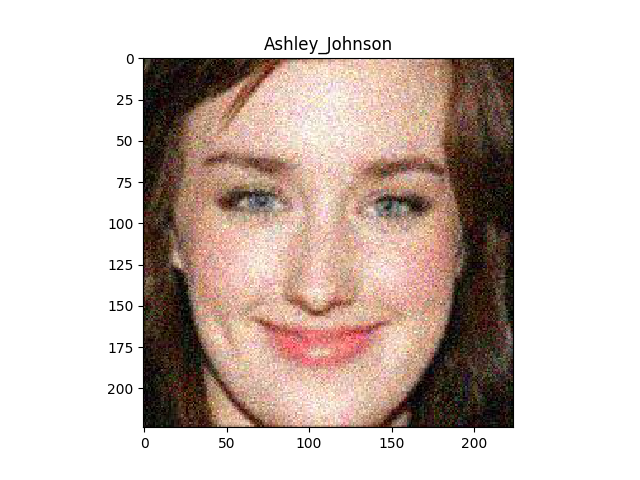

A Jupyter Widget

In [7]:
fig = plt.figure()
ax = plt.subplot(111)

def inference(img_file):
    dir_name = os.path.basename(os.path.dirname(img_file))
    img = imread(img_file)[:, :, :3].astype(np.float)
    
    # TensorFlow prediction
    tf_probabilities = tf_cnn.inference(tf_cnn.preprocess(img)[None, :])[0]
    tf_top_5_predictions = decode_single_prediction(tf_probabilities)
    print("[TensorFlow]")
    print(tf_top_5_predictions)
    
    # Tensorwow prediction
    my_probabilities = my_cnn.inference(img[None, :])[0]
    my_top_5_predictions = decode_single_prediction(my_probabilities)
    print("[TensorWow]")
    print(my_top_5_predictions)
    
    ax.imshow(img.astype(np.uint8))
    ax.set_title(dir_name)
    
interact(inference, img_file=widgets.SelectionSlider(options=img_files, value=img_files[0], continuous_update=False, description="Image file", layout=Layout(width="90%")));